In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import requests
import zipfile
import io
from nltk.corpus import stopwords
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display, clear_output

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Style configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Libraries loaded successfully.")

✅ Libraries loaded successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print("⏳ Downloading dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('SMSSpamCollection') as f:
        df = pd.read_csv(f, sep='\t', names=['label', 'message'], header=None)

# Map labels
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
print(f"✅ Dataset Loaded! Shape: {df.shape}")
df.head()

⏳ Downloading dataset...
✅ Dataset Loaded! Shape: (5572, 3)


,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


C:\Users\Admin\AppData\Local\Temp\ipykernel_8148\4138520286.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


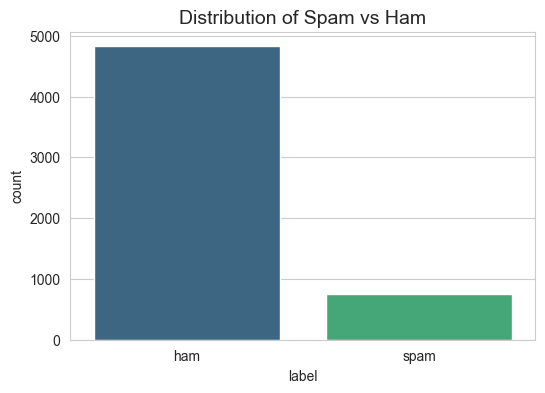

generating visuals...


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


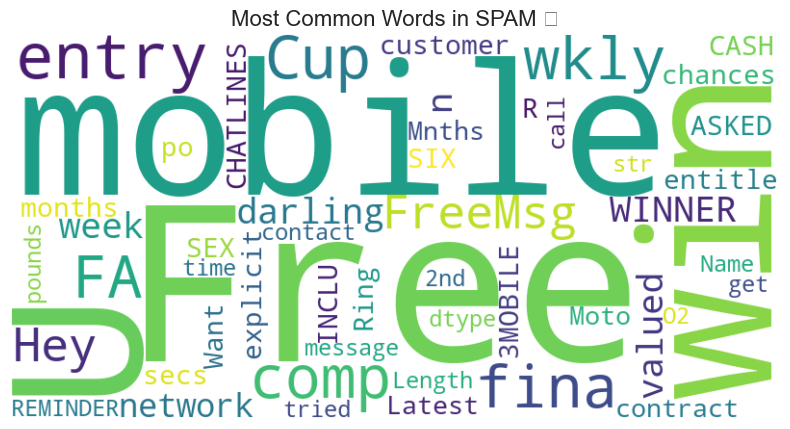

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


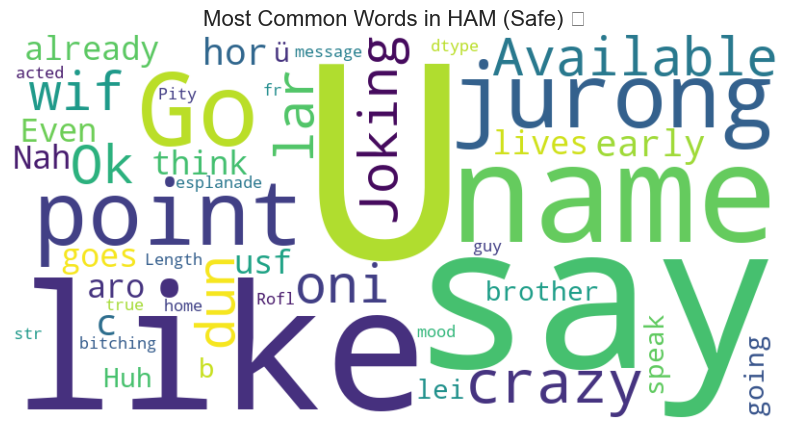

In [3]:
# 1. Plot Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Distribution of Spam vs Ham", fontsize=14)
plt.show()

# 2. Generate WordClouds
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, 
                          background_color ='white', 
                          stopwords=stop_words, 
                          min_font_size = 10).generate(str(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

print("generating visuals...")
generate_wordcloud(df[df['label']=='spam']['message'], "Most Common Words in SPAM 🚨")
generate_wordcloud(df[df['label']=='ham']['message'], "Most Common Words in HAM (Safe) ✅")

In [4]:
# Preprocessing Function
def clean_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

# Apply Cleaning
df['clean_message'] = df['message'].apply(clean_text)

# Vectorization
cv = CountVectorizer()
X = cv.fit_transform(df['clean_message'])
y = df['label_num']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes (Best for text)
model = MultinomialNB()
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"✅ Model Trained! Accuracy: {acc:.2%}")

✅ Model Trained! Accuracy: 97.49%


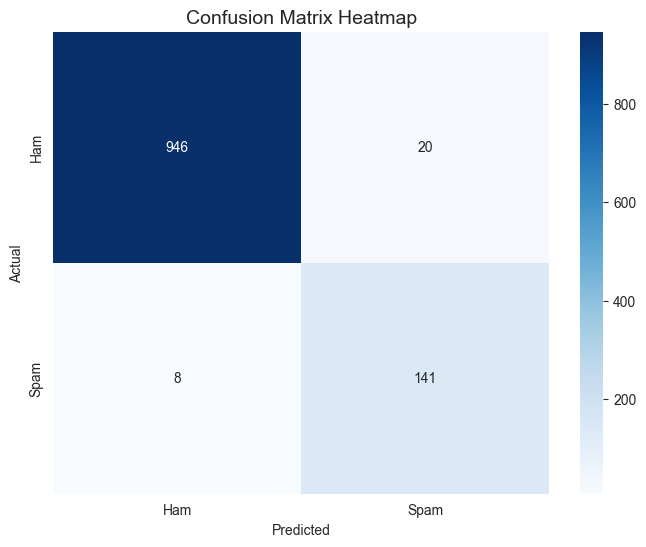

In [5]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap', fontsize=14)
plt.show()

In [6]:
#Widgets
text_input = widgets.Textarea(
    placeholder='Type a message here (e.g., "You won a lottery!")',
    description='Message:',
    layout=widgets.Layout(width='80%', height='100px')
)
button = widgets.Button(
    description='Check Spam',
    button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
    icon='search'
)
output = widgets.Output()

#Logic
def on_button_clicked(b):
    with output:
        clear_output()
        msg = text_input.value
        if not msg:
            print("⚠️ Please type a message first.")
            return
            
        # Clean & Predict
        clean_msg = clean_text(msg)
        vec_msg = cv.transform([clean_msg])
        pred = model.predict(vec_msg)[0]
        prob = model.predict_proba(vec_msg)[0]
        
        # Display nicely
        print("-" * 30)
        if pred == 1:
            print(f"🚨 SPAM DETECTED! (Confidence: {prob[1]*100:.1f}%)")
        else:
            print(f"✅ Safe Message (Ham). (Confidence: {prob[0]*100:.1f}%)")
        print("-" * 30)

button.on_click(on_button_clicked)

# Display UI
display(widgets.VBox([text_input, button, output]))